In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from jinja2 import escape
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,robust_scale,PolynomialFeatures,OneHotEncoder,LabelBinarizer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import eli5
from scipy.stats import norm
%matplotlib inline
sns.set(style='white')
sns.set_palette('deep')
import os

In [2]:
df = pd.read_csv("../A21_python_labs/data/books.csv",sep=',',error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [4]:

#since en-US ,en-GB , en are english we can group them into a same language-code
encoding = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'}} # Unify the langauge codes
df.replace(encoding, inplace=True)


# Convert data type of publication_date from object into date type
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')
print("publication_date is now of type :",df.publication_date.dtypes,"\n")
df[df['publication_date'].isnull()]#checking if all values are well-formed


#Since there are only 2 books with courrpted dates, I googled these 2 books to get the publication dates and put them manually
df.loc[df.bookID == 31373, 'publication_date'] = '1999-10-01'
df.loc[df.bookID == 45531, 'publication_date'] = '1975-10-01'
df[df['publication_date'].isnull()]

# Extract year of publication in a separate column
df['year'] = pd.DatetimeIndex(df['publication_date']).year 

# Rename the column to remove leading whitespaces
df.rename(columns = {'  num_pages': 'num_pages'}, inplace=True)

publication_date is now of type : datetime64[ns] 



In [5]:
# Add a new feature which has the number of occurences of each book
df['num_occ'] = df.groupby('title')['title'].transform('count') 


df['rate_occ'] = df['average_rating'] * df['num_occ'] #rating by occurence
df['rate_weight'] = df['average_rating'] * df['text_reviews_count']# rate weighted by review
df['rate_weight_2'] = df['average_rating'] * df['ratings_count']# rate weigth
df['rate_per_pages'] = df['average_rating'] * df['num_pages']#rate per page

In [6]:
numericaldata=[]

for i in df.columns:
    if df[i].dtypes=="int64" or df[i].dtypes=="float64":
        numericaldata.append(i)

df[numericaldata].describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,year,num_occ,rate_occ,rate_weight,rate_weight_2,rate_per_pages
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000,11123.000000,11123.000000,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099,2000.168300,1.241302,4.888351,2162.855219,7.209551e+04,1336.162010
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589,8.248887,0.875055,3.500185,10389.499981,4.532613e+05,1027.032037
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000,1900.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000,1998.000000,1.000000,3.800000,35.100000,4.063300e+02,768.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000,2003.000000,1.000000,4.000000,183.150000,2.936670e+03,1154.420000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000,2005.000000,1.000000,4.230000,928.105000,1.971079e+04,1648.480000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000,2020.000000,9.000000,38.880000,379669.970000,1.650562e+07,30907.200000


In [7]:
categoricaldata=[]

for i in df.columns:
    if df[i].dtypes=="object":
        categoricaldata.append(i)

df[categoricaldata].describe()

,title,authors,isbn,language_code,publication_date,publisher
count,11123,11123,11123,11123,11123,11123
unique,10348,6639,11123,24,3679,2290
top,The Iliad,Stephen King,0306801450,eng,2005-10-01 00:00:00,Vintage
freq,9,40,1,10537,56,318


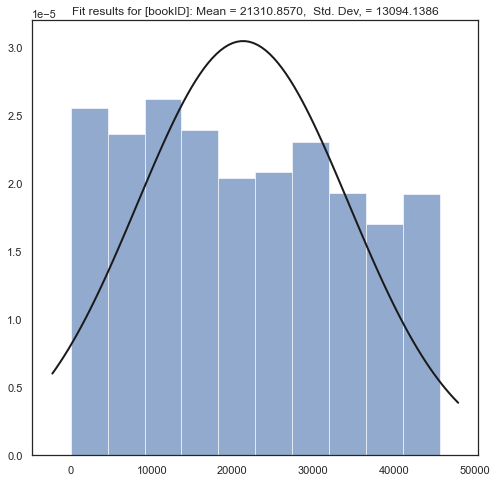

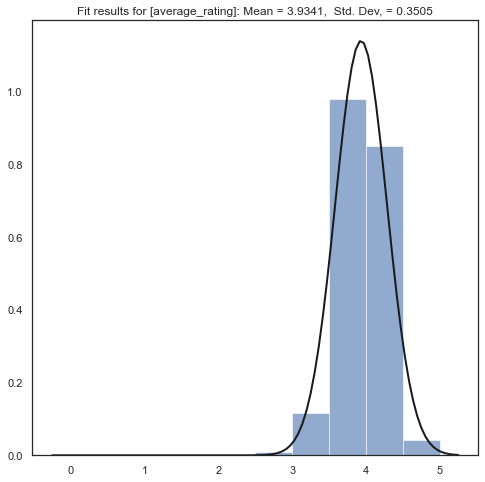

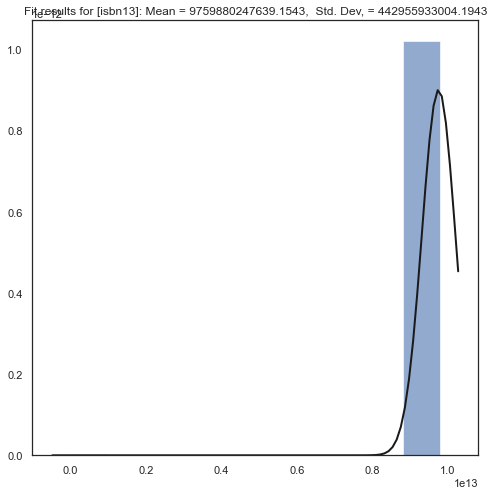

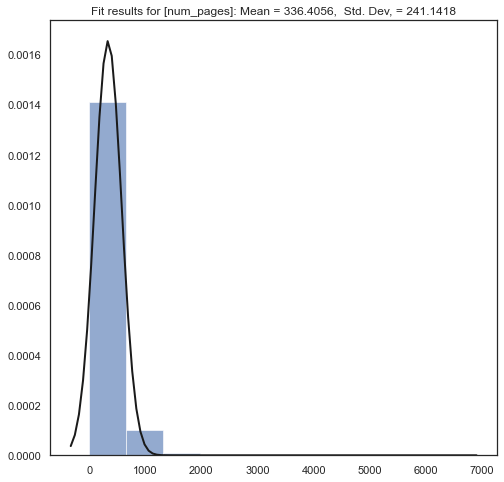

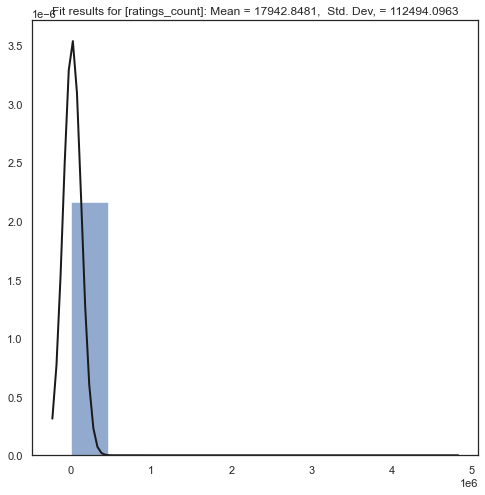

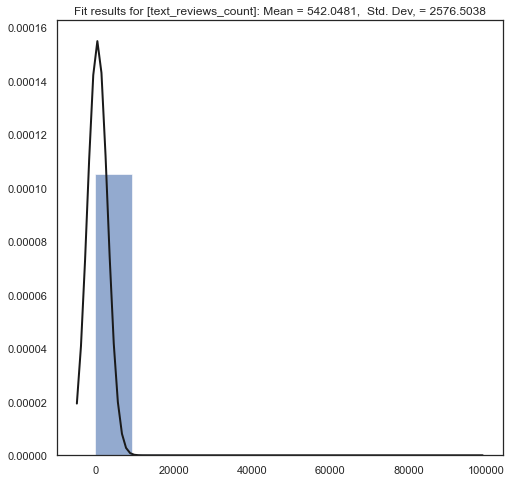

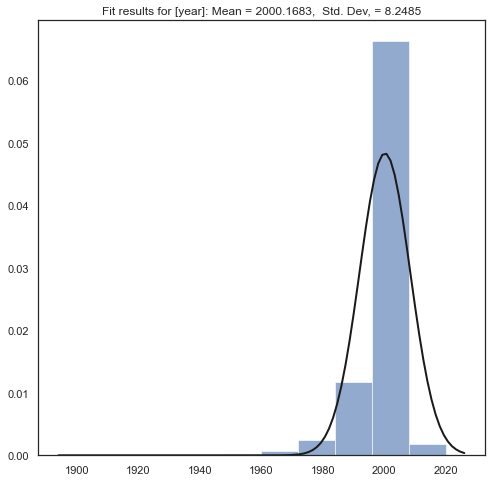

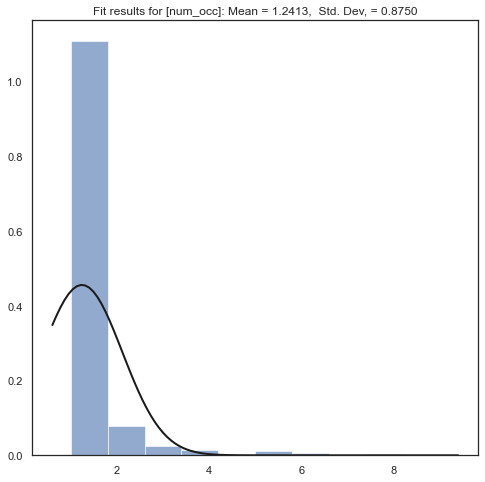

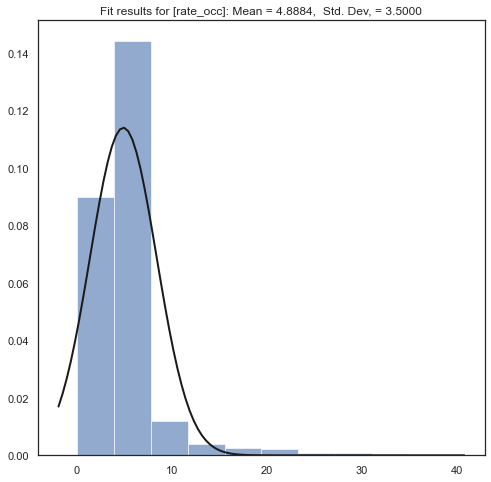

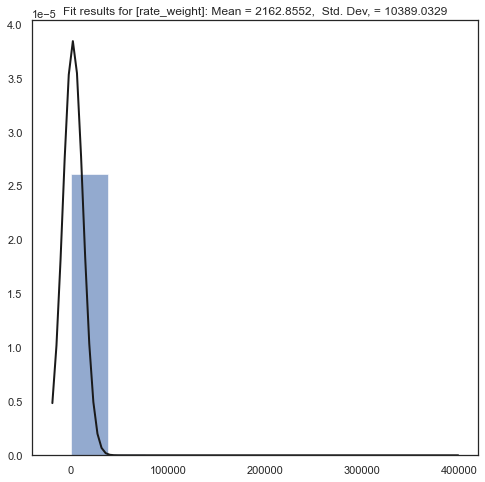

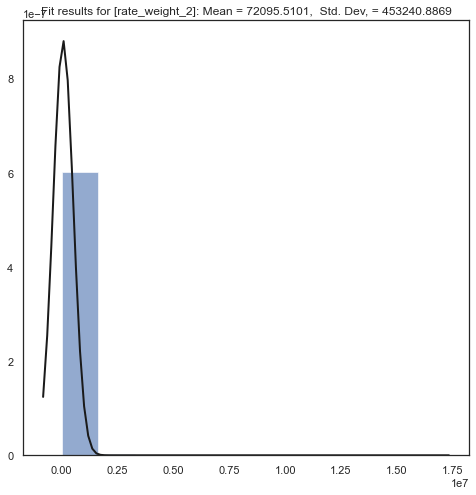

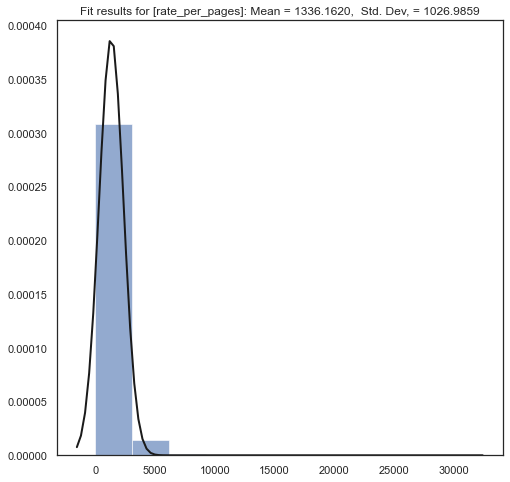

In [8]:
for i in df[numericaldata]:
    dMean, dStd = norm.fit(df[i])
    plt.figure(figsize = (8, 8))
    # Plot hist
    plt.hist(df[i], density=True, alpha=0.6)
        
        
    # Plot PDF.
    xmin, xmax = plt.xlim()
    xlin = np.linspace(xmin, xmax, 100)
    pdf = norm.pdf(xlin, dMean, dStd)
    plt.plot(xlin, pdf, 'k', linewidth=2)
    title = "Fit results for [" + i + "]: Mean = %.4f,  Std. Dev, = %.4f" % (dMean, dStd)
    plt.title(title)
        
        

In [ ]:
#the density of average_rating has the normal distribution based on the bell curve

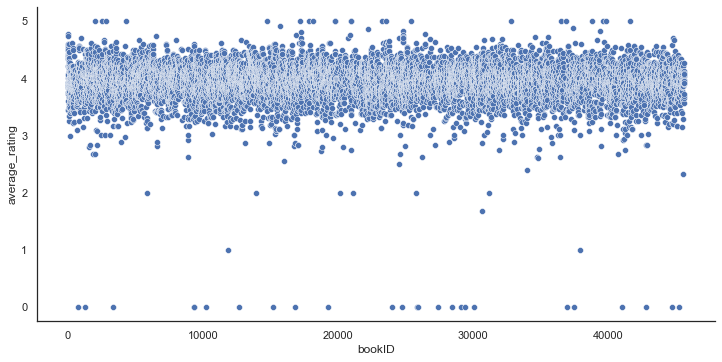

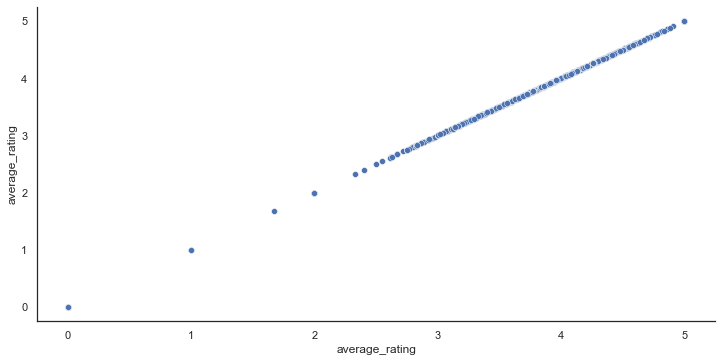

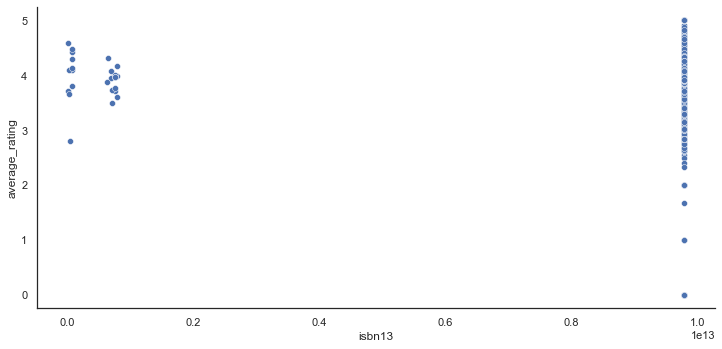

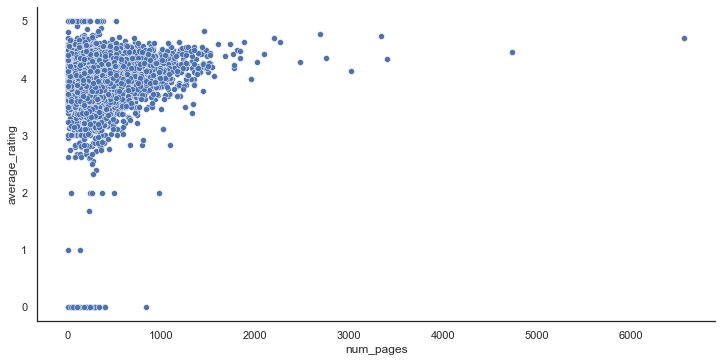

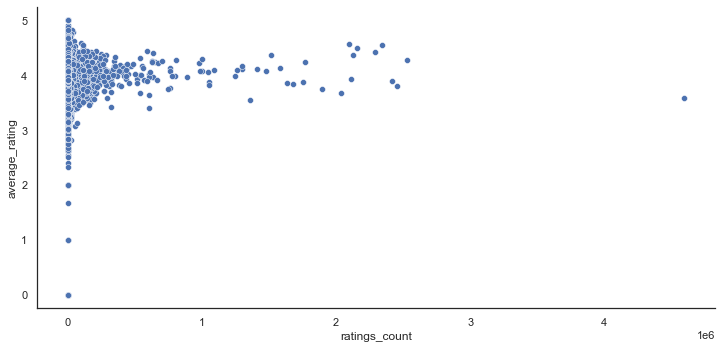

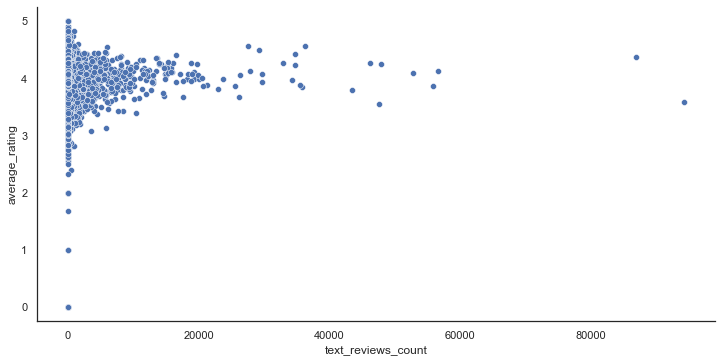

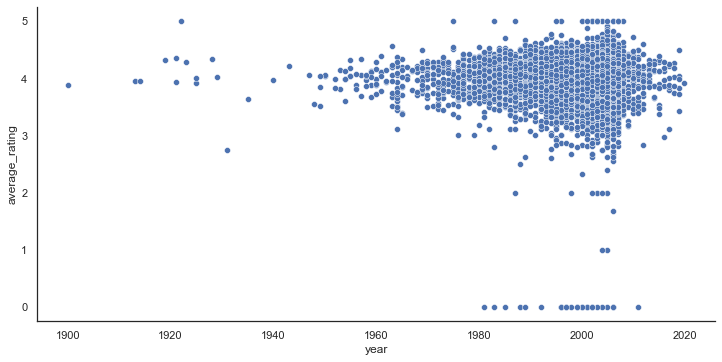

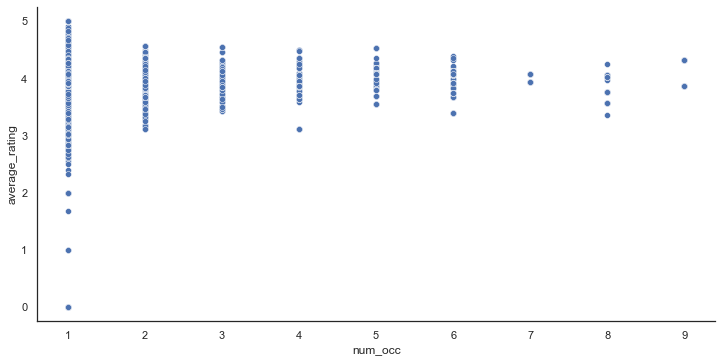

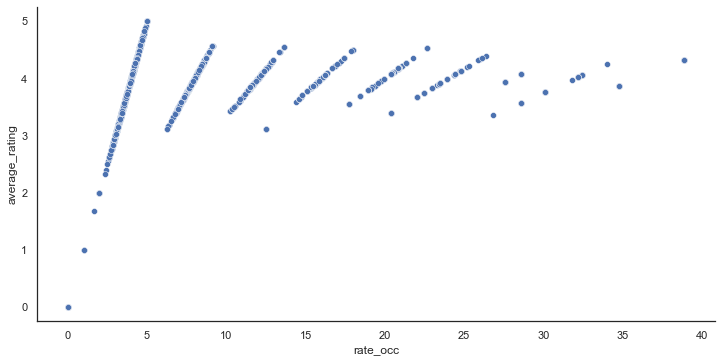

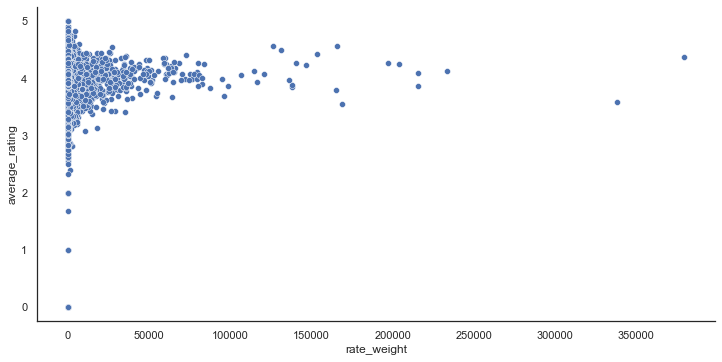

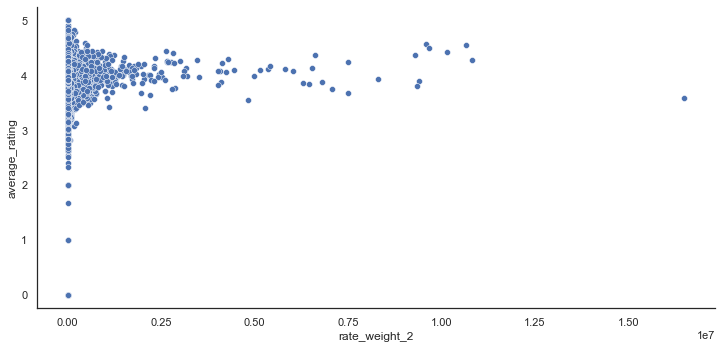

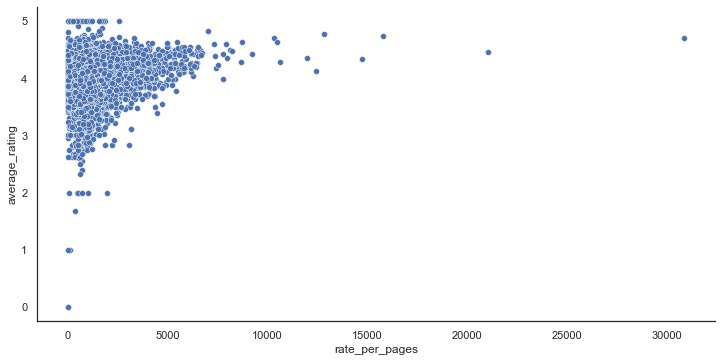

In [9]:
for i in df[numericaldata]:
    sns.relplot(x="{0}".format(i), y="average_rating", data=df, height=5, aspect = 2)

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,year,num_occ,rate_occ,rate_weight,rate_weight_2,rate_per_pages
bookID,1.000000,-0.036207,-0.002185,-0.026134,-0.076820,-0.081289,0.027327,-0.112645,-0.115602,-0.081075,-0.077622,-0.029263
average_rating,-0.036207,1.000000,-0.001965,0.150477,0.038224,0.033663,-0.031742,0.016227,0.127515,0.042373,0.044985,0.243642
isbn13,-0.002185,-0.001965,1.000000,-0.009818,0.005494,0.008152,-0.000349,0.013033,0.012688,0.007919,0.005294,-0.011621
num_pages,-0.026134,0.150477,-0.009818,1.000000,0.034337,0.036977,-0.019613,0.063057,0.081209,0.038998,0.036182,0.991624
ratings_count,-0.076820,0.038224,0.005494,0.034337,1.000000,0.865977,0.044568,0.092366,0.096611,0.860792,0.997043,0.036643
text_reviews_count,-0.081289,0.033663,0.008152,0.036977,0.865977,1.000000,0.066914,0.070006,0.074066,0.997503,0.861244,0.038182
year,0.027327,-0.031742,-0.000349,-0.019613,0.044568,0.066914,1.000000,-0.001678,-0.005138,0.065819,0.044116,-0.026348
num_occ,-0.112645,0.016227,0.013033,0.063057,0.092366,0.070006,-0.001678,1.000000,0.991943,0.069620,0.091423,0.060569
rate_occ,-0.115602,0.127515,0.012688,0.081209,0.096611,0.074066,-0.005138,0.991943,1.000000,0.074954,0.096809,0.089326
rate_weight,-0.081075,0.042373,0.007919,0.038998,0.860792,0.997503,0.065819,0.069620,0.074954,1.000000,0.860903,0.041317


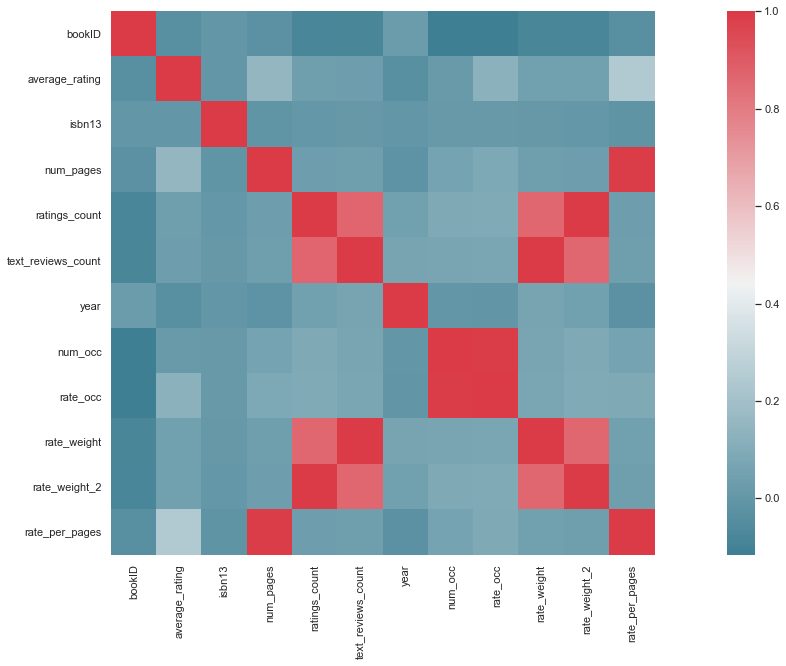

In [10]:
#correlation between numerical variables 

fig = plt.gcf()
fig.set_size_inches(26, 10)
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

df[numericaldata].corr()

no remarkable correlation apart from the variables created with their originals variables

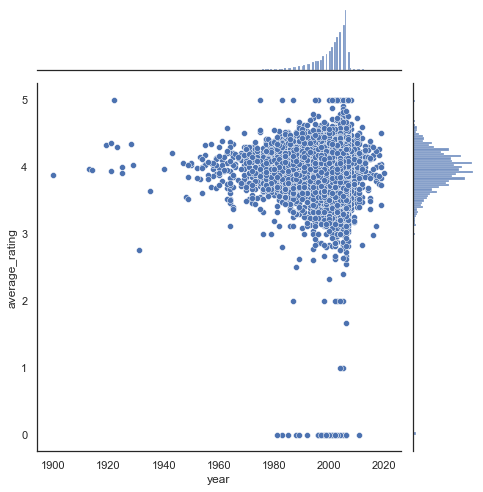

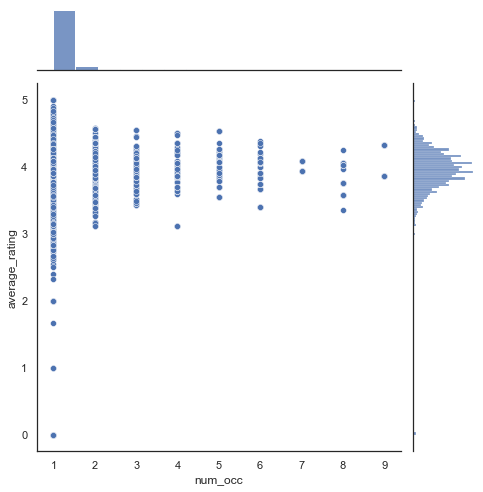

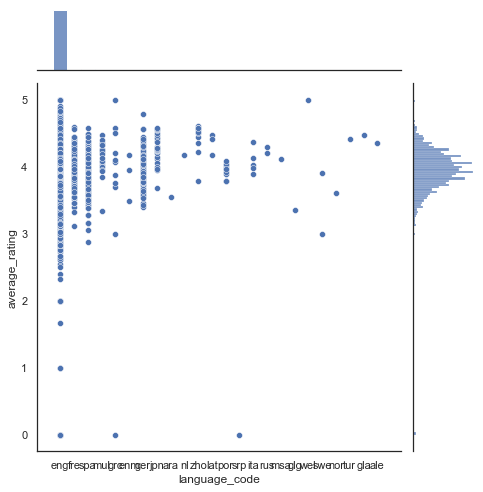

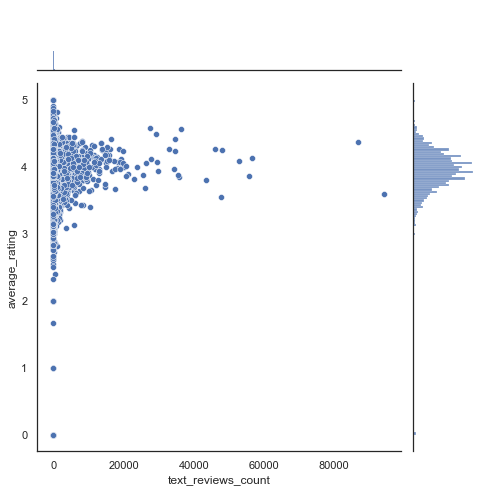

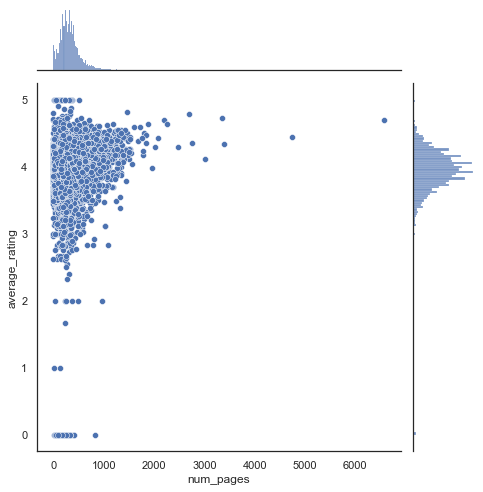

In [11]:
for i in ["year","num_occ","language_code","text_reviews_count","num_pages"]:
    sns.jointplot(x="{}".format(i), y="average_rating", data=df, height=7)#, aspect = 2)
    

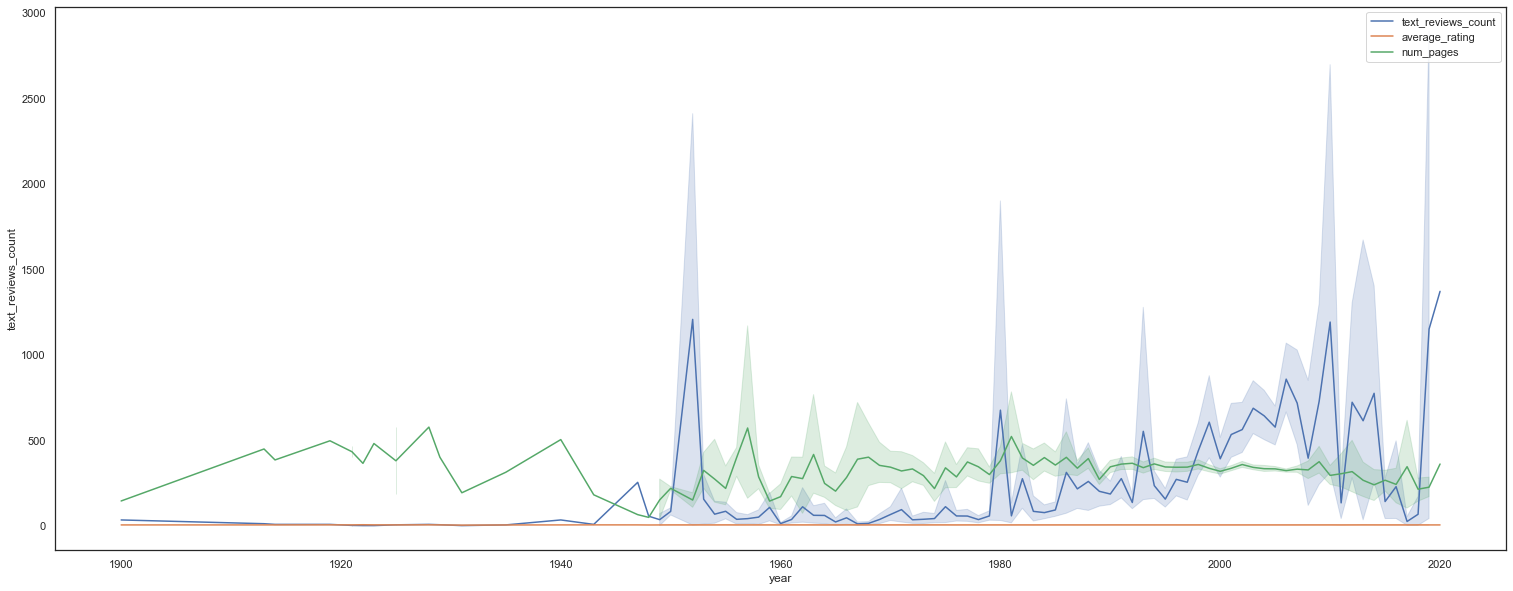

In [12]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="year", y="text_reviews_count", data=df)
sns.lineplot(x="year", y="average_rating", data=df)
sns.lineplot(x="year", y="num_pages", data=df)
plt.legend(labels=["text_reviews_count","average_rating","num_pages"])


-Which authors wrote the most books?

In [13]:
#Number of authors
allAuthors = df.authors.unique()
y_pos = np.arange(len(allAuthors))

print(len(allAuthors))

top10Authors = df[['authors', 'title']].groupby(['authors']).count()
top10Authors = top10Authors.sort_values(by=['title'], ascending=False)
top10Authors = top10Authors.head(10)
top10Authors

6639


,title
authors,
Stephen King,40
P.G. Wodehouse,40
Rumiko Takahashi,39
Orson Scott Card,35
Agatha Christie,33
Piers Anthony,30
Mercedes Lackey,29
Sandra Brown,29
Dick Francis,28


-Who are the top 10 highly rated Authors?
-Who are the top 10 highly rated

In [14]:
#supposing that 4/5 is upper than Average and Median , we can consider it at a upper ratting
GoodRatedAuthors2 = df[df['average_rating']>=4]
GoodRatedAuthors2=GoodRatedAuthors2[['authors', 'title','average_rating']]\
                    .groupby(['authors'])\
                    .agg({'title':['count'],'average_rating': ['mean', 'min', 'max']})\
                    .sort_values(('title','count'), ascending = False)
GoodRatedAuthors2.head(10)

title average_rating            
                    count           mean   min   max
authors                                             
Rumiko Takahashi       36       4.207222  4.04  4.36
P.G. Wodehouse         34       4.194118  4.01  4.48
Mercedes Lackey        19       4.117368  4.01  4.27
Stephen King           18       4.191111  4.00  4.54
Terry Pratchett        18       4.197778  4.00  4.38
J.R.R. Tolkien         17       4.395882  4.05  4.59
Dr. Seuss              15       4.134667  4.00  4.35
Laurell K. Hamilton    15       4.109333  4.01  4.54
Agatha Christie        14       4.169286  4.01  4.39
Tite Kubo              14       4.326429  4.22  4.42

for authors who have more than 4/5 rating:
- Rumiko Takahashi has 36 books with 4.2 as average rating 
- P.G. Wodehouse has 34 books with 4.2 as average rating 
- Mercedes Lackey has 19 books with 4.11 as average rating ...

-Who are the top 10 highly rated books

In [15]:
GoodRatedTitle=df[[ 'title','average_rating']].groupby(['title'])\
                            .agg({'title':['count'],'average_rating': ['mean']})\
                            .sort_values(('title','count'), ascending = False)
GoodRatedTitle.columns=['count','mean_rating']
GoodRatedTitle.head(10)

,count,mean_rating
title,,
The Iliad,9,3.86000
The Brothers Karamazov,9,4.32000
Anna Karenina,8,4.05000
'Salem's Lot,8,4.04875
Gulliver's Travels,8,3.59250
The Odyssey,8,3.76000
The Picture of Dorian Gray,7,4.08000
A Midsummer Night's Dream,7,3.94000
The Great Gatsby,6,3.90500


In [ ]:
sns.pairplot(df[numericaldata])
plt.show()